In [1]:
%cd /home/user_hys/User/hys/Dual_cone/pinnsformer

/home/user_hys/User/hys/Dual_cone/pinnsformer


In [2]:
%ls

convection_pinnsformer_pred.png  model/        pyhessian.py  vis_landscape.py
convection_pinns_pred.png        optim/        README.md
demo/                            __pycache__/  util.py


In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io

from optim.DCGD_Center2 import DualCenter2

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [4]:
import os 

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  

In [6]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#device = 'cuda:0'

In [19]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [20]:
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
mat = scipy.io.loadmat('/home/user_hys/User/hys/Dual_cone/pinnsformer/demo/convection/convection.mat')
u = mat['u'].reshape(101,101)


In [21]:
# Train PINNs 
model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
#optim = torch.optim.Adam(model.parameters(), lr=0.001)
#base_optim = torch.optim.Adam(model.parameters(), lr=0.001)
#optim = DualCenter2(base_optim, num_pde=1)

print(model)
print(get_n_params(model))

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


/tmp/ipykernel_1810005/93869651.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [22]:
loss_track = []
best_loss = 1000000
rl1 = 0
rl2 = 0

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss
    
    def dcgd_closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss_bd = loss_bc + loss_ic

        return [loss_res, loss_bd]
    optim.step(closure)
    #losses = dcgd_closure()
'''    if sum(losses) < best_loss:
        best_loss = sum(losses)
        with torch.no_grad():
            pred = model(x_test, t_test)[:,0:1]
            pred = pred.cpu().detach().numpy()
        pred = pred.reshape(101,101)
        u = mat['u'].reshape(101,101)
        rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
        rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
        #print('relative L1 error: {:4f}'.format(rl1))
        #print('relative L2 error: {:4f}'.format(rl2))
    optim.step(losses)'''

  0%|          | 0/500 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'data'

In [12]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000361, Loss_BC: 0.015729, Loss_IC: 0.000584
Train Loss: 0.016674


In [13]:

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

relative L1 error: 0.000000
relative L2 error: 0.000000


In [11]:
print(loss_track)

[[18.57148551940918, 0.3027685284614563, 0.4546215534210205], [2666.3974609375, 39.33141326904297, 19.257225036621094], [176.3318328857422, 2.5709102153778076, 2.151442050933838], [437.49493408203125, 6.701533317565918, 2.3729238510131836], [753.2499389648438, 11.392913818359375, 4.170844078063965], [294.5289611816406, 4.423778057098389, 1.7276042699813843], [0.5270417332649231, 0.0004226956225465983, 0.5058649778366089], [257.7687683105469, 3.885633707046509, 2.7327749729156494], [434.8277587890625, 6.5238847732543945, 4.0722503662109375], [258.2416076660156, 3.8911328315734863, 2.7628536224365234], [43.73603439331055, 0.6701030135154724, 1.019230842590332], [13.577041625976562, 0.16379433870315552, 0.4684845507144928], [122.25827026367188, 1.7100750207901, 0.9422554969787598], [202.03050231933594, 2.8497314453125, 1.3779979944229126], [174.58151245117188, 2.4484403133392334, 1.2293697595596313], [83.91771697998047, 1.147805094718933, 0.7499171495437622], [12.422916412353516, 0.141963

In [13]:
import matplotlib.pyplot as plt

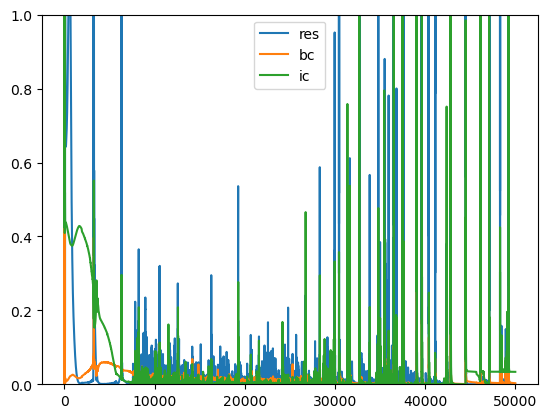

In [36]:
plt.plot(np.array(loss_track)[:,0], label='res')
plt.plot(np.array(loss_track)[:,1], label='bc')
plt.plot(np.array(loss_track)[:,2], label='ic')
plt.legend()
plt.ylim((0,1))
plt.show()

relative L1 error: 0.779649
relative L2 error: 0.841684


/tmp/ipykernel_1810005/2650145131.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)


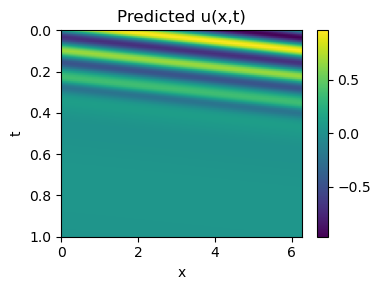

In [15]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('/home/user_hys/User/hys/Dual_cone/pinnsformer/demo/convection/convection.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinns_pred.png')
plt.show()

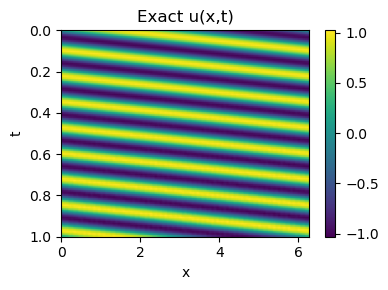

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_exact.png')
plt.show()

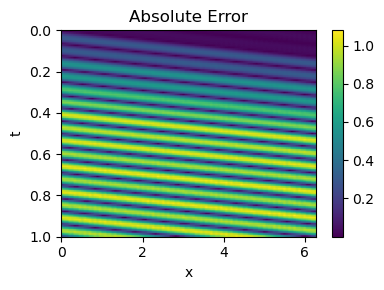

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinns_error.png')
plt.show()